In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")


Load data

In [2]:
sales_train = pd.read_csv("sales_train.csv", parse_dates=['date'])
print("Number of datapoints in main data:", len(sales_train))
inventory = pd.read_csv("inventory.csv")
print("Number of datapoints in inventory data:", len(inventory))
calendar = pd.read_csv("calendar.csv", parse_dates=['date'])
print("Number of datapoints in calendar data:", len(calendar))
sales_train.head()


Number of datapoints in main data: 4007419
Number of datapoints in inventory data: 5432
Number of datapoints in calendar data: 23016


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


In [3]:
inventory.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [4]:
calendar.head()



,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


In [5]:
date=calendar[["date"]]
duplicates = date[date.duplicated(keep="first")]
print(duplicates)

            date
28    2022-01-20
72    2023-08-19
163   2024-11-03
170   2020-08-06
189   2024-07-24
...          ...
23011 2019-04-20
23012 2018-03-31
23013 2017-04-15
23014 2023-04-08
23015 2024-03-30

[19728 rows x 1 columns]


In [6]:
#check missing values
print("The missing value summary for training data:")
print(sales_train.isnull().sum().sort_values(ascending=False))  
print("-----------------------------------------------------------------")  
print("The missing value summary for inventory data:")
print(inventory.isnull().sum().sort_values(ascending=False))  
print("-----------------------------------------------------------------")  
print("The missing value summary for calendar data:")
print(calendar.isnull().sum().sort_values(ascending=False))  
print("-----------------------------------------------------------------")  

The missing value summary for training data:
total_orders       52
sales              52
unique_id           0
date                0
warehouse           0
sell_price_main     0
availability        0
type_0_discount     0
type_1_discount     0
type_2_discount     0
type_3_discount     0
type_4_discount     0
type_5_discount     0
type_6_discount     0
dtype: int64
-----------------------------------------------------------------
The missing value summary for inventory data:
unique_id              0
product_unique_id      0
name                   0
L1_category_name_en    0
L2_category_name_en    0
L3_category_name_en    0
L4_category_name_en    0
warehouse              0
dtype: int64
-----------------------------------------------------------------
The missing value summary for calendar data:
holiday_name              22086
date                          0
holiday                       0
shops_closed                  0
winter_school_holidays        0
school_holidays               0
wareho

In [7]:
#There is only 52 rows have missing value in training data. We can simply drop all the missing values.
sales_train = sales_train.dropna()

In [8]:
#Check data type and info
sales_train.info()
print("-----------------------------------------------------------------")
inventory.info()
print("-----------------------------------------------------------------")
calendar.info()
print("-----------------------------------------------------------------")

<class 'pandas.core.frame.DataFrame'>
Index: 4007367 entries, 0 to 4007418
Data columns (total 14 columns):
 #   Column           Dtype         
---  ------           -----         
 0   unique_id        int64         
 1   date             datetime64[ns]
 2   warehouse        object        
 3   total_orders     float64       
 4   sales            float64       
 5   sell_price_main  float64       
 6   availability     float64       
 7   type_0_discount  float64       
 8   type_1_discount  float64       
 9   type_2_discount  float64       
 10  type_3_discount  float64       
 11  type_4_discount  float64       
 12  type_5_discount  float64       
 13  type_6_discount  float64       
dtypes: datetime64[ns](1), float64(11), int64(1), object(1)
memory usage: 458.6+ MB
-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5432 entries, 0 to 5431
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dt

Feature engineering

In [9]:
#merge three dataset
inventory=inventory.drop(columns="warehouse")
data = sales_train.merge(calendar, on=['date','warehouse'] , how='left').merge(inventory, on=['unique_id'], how='left')
data.info()
  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007367 entries, 0 to 4007366
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_id               int64         
 1   date                    datetime64[ns]
 2   warehouse               object        
 3   total_orders            float64       
 4   sales                   float64       
 5   sell_price_main         float64       
 6   availability            float64       
 7   type_0_discount         float64       
 8   type_1_discount         float64       
 9   type_2_discount         float64       
 10  type_3_discount         float64       
 11  type_4_discount         float64       
 12  type_5_discount         float64       
 13  type_6_discount         float64       
 14  holiday_name            object        
 15  holiday                 int64         
 16  shops_closed            int64         
 17  winter_school_holidays  int64         
 18  sc

In [10]:
# Summary the discount value: Multiple discounts with different type can be run at the same time, but always the highest possible discount among these types is used for sales.
data['discount'] = data[['type_0_discount', 'type_1_discount', 'type_2_discount', 
                     'type_3_discount', 'type_4_discount', 'type_5_discount', 
                     'type_6_discount']].max(axis=1)

In [11]:
#One-hot encoding
#To reduce the memory occupied, only keep the columns that will be useful for prediction
#Because this is a prediction task, we shouldn't include the features we don't know yet.
data_cleaned=data[["unique_id","date","warehouse","sales","sell_price_main","discount",'L1_category_name_en','holiday','shops_closed','winter_school_holidays','school_holidays']]
# One-hot encode for the category values
encoded_L1 = pd.get_dummies(data_cleaned['L1_category_name_en'], prefix='category')
encoded_warehouse = pd.get_dummies(data_cleaned['warehouse'], prefix='warehouse')
data_cleaned = pd.concat([data_cleaned, encoded_L1, encoded_warehouse], axis=1)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007367 entries, 0 to 4007366
Data columns (total 21 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   unique_id                     int64         
 1   date                          datetime64[ns]
 2   warehouse                     object        
 3   sales                         float64       
 4   sell_price_main               float64       
 5   discount                      float64       
 6   L1_category_name_en           object        
 7   holiday                       int64         
 8   shops_closed                  int64         
 9   winter_school_holidays        int64         
 10  school_holidays               int64         
 11  category_Bakery               bool          
 12  category_Fruit and vegetable  bool          
 13  category_Meat and fish        bool          
 14  warehouse_Brno_1              bool          
 15  warehouse_Budapest_1          bo

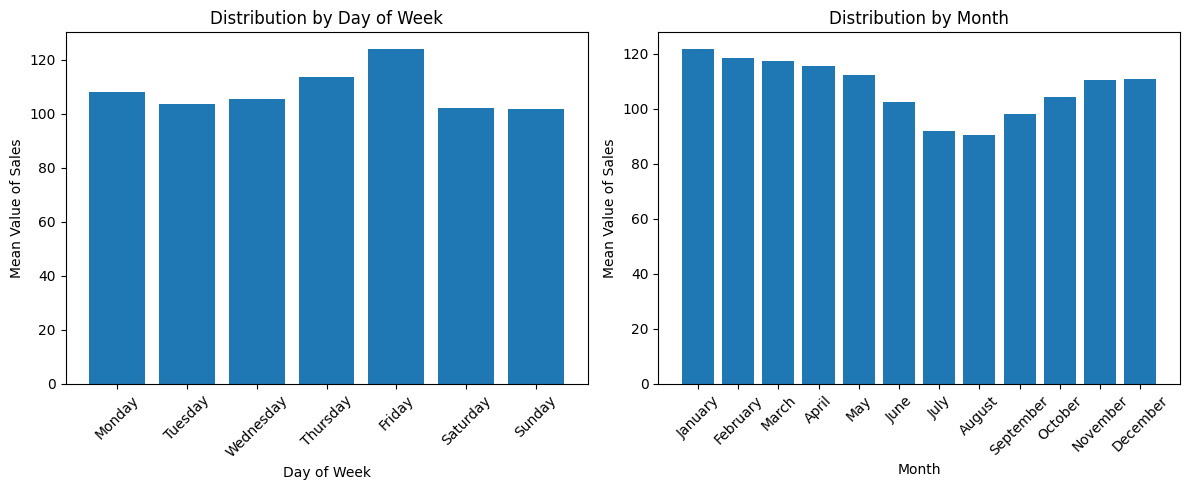

<Figure size 640x480 with 0 Axes>

In [12]:
#create date time information, which can be very useful for prediction
data_cleaned['day_of_week'] = data_cleaned['date'].dt.day_name()
data_cleaned['month'] = data_cleaned['date'].dt.month_name()

#Define time order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Sale by week
day_of_week_counts = data_cleaned.groupby('day_of_week')['sales'].mean().reindex(weekday_order, fill_value=0)

# Sale by month
month_counts = data_cleaned.groupby('month')['sales'].mean().reindex(month_order, fill_value=0)

# 2 plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sale by week for plot
axes[0].bar(day_of_week_counts.index, day_of_week_counts.values)
axes[0].set_title("Distribution by Day of Week")
axes[0].set_xlabel("Day of Week")
axes[0].set_ylabel("Mean Value of Sales")
axes[0].tick_params(axis='x', rotation=45)

# Sale by month for plot
axes[1].bar(month_counts.index, month_counts.values)
axes[1].set_title("Distribution by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Mean Value of Sales")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.savefig("Distribution by Week and Month.png")

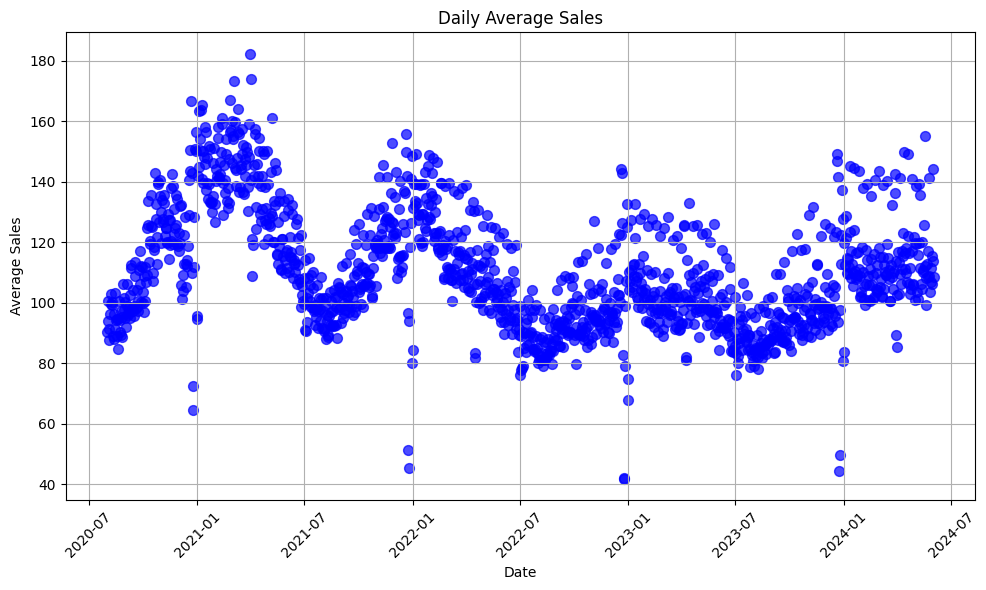

<Figure size 640x480 with 0 Axes>

In [13]:
#Plot average sales by time
daily_sales = data_cleaned.groupby('date')['sales'].mean().reset_index()


plt.figure(figsize=(10, 6))
plt.scatter(daily_sales['date'], daily_sales['sales'], color='blue', s=50, alpha=0.7)


plt.title("Daily Average Sales")
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.xticks(rotation=45)  
plt.grid(True)  


plt.tight_layout()
plt.show()
plt.savefig("Daily Average Sales.png")

In [14]:
#save cleaned data
data_cleaned.to_csv("data_cleaned.csv", index=False)

In [15]:
newest_date=data_cleaned['date'].max()
oldest_date=data_cleaned['date'].min()
days_covered = (data_cleaned['date'].max() - data_cleaned['date'].min()).days + 1
weeks_covered=days_covered/7
print(f"The data covers {days_covered} days, and roughly {weeks_covered} weeks, from {oldest_date} to {newest_date}.")

The data covers 1402 days, and roughly 200.28571428571428 weeks, from 2020-08-01 00:00:00 to 2024-06-02 00:00:00.


In [16]:
#Because the dataset is too large, I select 50 unique ids which works best to cover the full time line.
counts = data_cleaned['unique_id'].value_counts().sort_values(ascending=False)


top_50_ids = counts.head(50).index


data_cleaned_50id = data_cleaned[data_cleaned['unique_id'].isin(top_50_ids)]
data_cleaned_50id.to_csv("data_cleaned_50id.csv", index=False)

counts = data_cleaned_50id['unique_id'].value_counts()

print("Top 50 unique_id by count:")
for unique_id, count in counts.items():
    print(f"ID: {unique_id}, Count: {count}")

Top 50 unique_id by count:
ID: 4540, Count: 1402
ID: 1998, Count: 1402
ID: 2125, Count: 1402
ID: 1997, Count: 1402
ID: 80, Count: 1402
ID: 4523, Count: 1402
ID: 4755, Count: 1402
ID: 4710, Count: 1402
ID: 2935, Count: 1402
ID: 2562, Count: 1402
ID: 4610, Count: 1402
ID: 2560, Count: 1402
ID: 2602, Count: 1402
ID: 1176, Count: 1402
ID: 4611, Count: 1402
ID: 2187, Count: 1401
ID: 2565, Count: 1401
ID: 2938, Count: 1401
ID: 2945, Count: 1401
ID: 2563, Count: 1401
ID: 2567, Count: 1401
ID: 4046, Count: 1401
ID: 4709, Count: 1401
ID: 4233, Count: 1401
ID: 4236, Count: 1401
ID: 4403, Count: 1401
ID: 2583, Count: 1401
ID: 2123, Count: 1401
ID: 2561, Count: 1401
ID: 1999, Count: 1401
ID: 2564, Count: 1401
ID: 1996, Count: 1401
ID: 2979, Count: 1400
ID: 4525, Count: 1400
ID: 4402, Count: 1400
ID: 393, Count: 1400
ID: 4234, Count: 1400
ID: 2339, Count: 1400
ID: 4198, Count: 1400
ID: 4627, Count: 1400
ID: 2232, Count: 1400
ID: 3125, Count: 1400
ID: 4904, Count: 1400
ID: 730, Count: 1400
ID: 4235,

Baseline Model-autoETS Model

In [33]:
#!pip install --upgrade threadpoolctl
#!pip install statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from tqdm import tqdm

In [34]:
df=pd.read_csv("data_cleaned_50id.csv", parse_dates=['date'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70043 entries, 0 to 70042
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   unique_id                     70043 non-null  int64         
 1   date                          70043 non-null  datetime64[ns]
 2   warehouse                     70043 non-null  object        
 3   sales                         70043 non-null  float64       
 4   sell_price_main               70043 non-null  float64       
 5   discount                      70043 non-null  float64       
 6   L1_category_name_en           70043 non-null  object        
 7   holiday                       70043 non-null  int64         
 8   shops_closed                  70043 non-null  int64         
 9   winter_school_holidays        70043 non-null  int64         
 10  school_holidays               70043 non-null  int64         
 11  category_Bakery             

In [35]:
newest_date=df['date'].max()
oldest_date=df['date'].min()
days_covered = (df['date'].max() - df['date'].min()).days + 1
weeks_covered=days_covered/7
print(f"The data covers {days_covered} days, and roughly {weeks_covered} weeks, from {oldest_date} to {newest_date}.")

The data covers 1402 days, and roughly 200.28571428571428 weeks, from 2020-08-01 00:00:00 to 2024-06-02 00:00:00.


In [36]:
# Define the MASE function for autoETS
def mase(y, y_pred, y_train, seasonality=7):

    mae = np.mean(np.abs(y - y_pred))
    naive_forecast_errors = np.abs(y_train[seasonality:] - y_train[:-seasonality])
    scaling_factor = np.mean(naive_forecast_errors)
    return mae / scaling_factor

# Leave-One-Out Cross-Validation for last m points
def leave_one_out_cv_last_m_with_naive(df, m, h, model, seasonality=7):
   
    errors_autoets = []  # Store actual and predicted values for AutoETS
    errors_naive = []    # Store actual and predicted values for naive forecast
    start_index = len(df) - m  # Start index for cross-validation

    for i in range(start_index, len(df) - h + 1):
        # Training and test split
        train_subset = df.iloc[:i]  # Use all points up to the current fold
        test_subset = df.iloc[i:i + h]

        # Fit the model on the training subset
        autoets = model.fit(train_subset['y'].values)

        # Predict for the test subset using AutoETS
        y_hat_autoets = autoets.predict(h=h).get("mean")
        errors_autoets.extend(zip(test_subset['y'].values, y_hat_autoets))

        # Calculate naive forecast
        y_hat_naive = train_subset['y'].iloc[-seasonality:].values.tolist() * h
        y_hat_naive = y_hat_naive[:h]  # Ensure forecast length matches h
        errors_naive.extend(zip(test_subset['y'].values, y_hat_naive))

    # Calculate MASE for AutoETS
    actual_autoets = np.array([e[0] for e in errors_autoets])
    predicted_autoets = np.array([e[1] for e in errors_autoets])
    train_series = df['y'].values  # Full training series for scaling
    mase_autoets = mase(actual_autoets, predicted_autoets, train_series)

    # Calculate MASE for naive forecast
    actual_naive = np.array([e[0] for e in errors_naive])
    predicted_naive = np.array([e[1] for e in errors_naive])
    mase_naive = mase(actual_naive, predicted_naive, train_series)

    return mase_autoets, mase_naive

In [37]:
data_autoETS=df[['warehouse',"date","sales"]]
data_autoETS = data_autoETS.groupby(['date', 'warehouse'], as_index=False).agg({'sales': 'sum'})

In [38]:
m = 70  # Only consider the last 10% points for cross-validation
h = 14  # Number of steps ahead for forecasting
seasonality = 7  # Weekly seasonality for daily data
unique_ids = data_autoETS['warehouse'].unique()
results = []

# Loop through each store_id with progress tracking
for unique_id in tqdm(unique_ids, desc="Processing all store_id series"):
    autoETS_warehouse = data_autoETS.loc[data_autoETS["warehouse"] == unique_id, ['date', "warehouse", 'sales']]
    autoETS_warehouse = autoETS_warehouse.rename(columns={'date': 'ds', 'sales': 'y', "warehouse": 'unique_id'})
    
    model = AutoETS(model=["Z", "Z", "Z"], alias="AutoETS", damped=True, season_length=seasonality)
    mase_autoets, mase_naive = leave_one_out_cv_last_m_with_naive(autoETS_warehouse, m, h, model, seasonality)
    results.append({"unique_id": unique_id, "AutoETS_MASE": mase_autoets, "Naive_MASE": mase_naive})

# Create a summary table
summary_table = pd.DataFrame(results)

# Calculate average MASE for both AutoETS and naive forecasts
average_autoets_mase = summary_table["AutoETS_MASE"].mean()
average_naive_mase = summary_table["Naive_MASE"].mean()


print(f"\nAverage AutoETS MASE across all series: {average_autoets_mase}")
print(f"Average Naive MASE across all series: {average_naive_mase}")
print(summary_table)

Processing all store_id series: 100%|██████████| 5/5 [03:40<00:00, 44.03s/it]


Average AutoETS MASE across all series: 0.748215311913968
Average Naive MASE across all series: 0.8712615744599755
    unique_id  AutoETS_MASE  Naive_MASE
0      Brno_1      0.648097    0.795502
1  Budapest_1      0.503416    0.611641
2    Prague_1      1.053573    1.242138
3    Prague_2      0.800703    0.883239
4    Prague_3      0.735288    0.823788


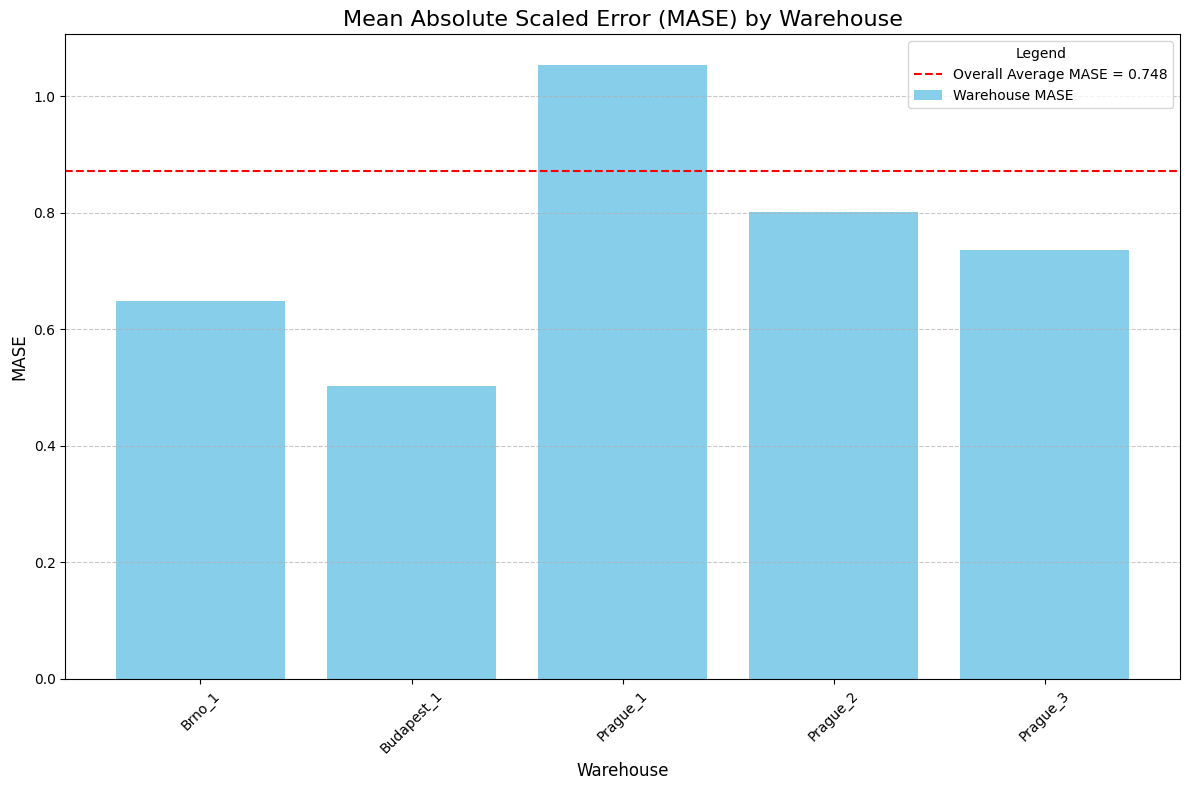

In [39]:
import matplotlib.pyplot as plt



# Plot the MASE for each warehouse
plt.figure(figsize=(12, 8))
plt.bar(summary_table['unique_id'], summary_table['AutoETS_MASE'], color='skyblue', label='Warehouse MASE')

# Add a horizontal line for the overall average MASE
plt.axhline(y=average_naive_mase, color='red', linestyle='--', label=f'Overall Average MASE = {average_autoets_mase:.3f}')

# Customize the plot
plt.title('Mean Absolute Scaled Error (MASE) by Warehouse', fontsize=16)
plt.xlabel('Warehouse', fontsize=12)
plt.ylabel('MASE', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Legend', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("AutoETS MASE.png")
plt.show()

In [40]:
from statsforecast.models import AutoETS
import pandas as pd
from tqdm import tqdm
import numpy as np
from datetime import timedelta

# Load data
df = pd.read_csv("data_cleaned_50id.csv", parse_dates=['date'])
data_autoETS = df[['warehouse', "date", "sales"]]
data_autoETS = data_autoETS.groupby(['date', 'warehouse'], as_index=False).agg({'sales': 'sum'})

# Parameters
h = 14  # Forecasting horizon (14 days)
seasonality = 7  # Weekly seasonality

unique_ids = data_autoETS['warehouse'].unique()

# List to store results
daily_results = []

# Rolling forecast for each warehouse
for unique_id in tqdm(unique_ids, desc="Day-by-day forecasting for each warehouse"):
    # Filter data for the specific warehouse
    warehouse_data = data_autoETS.loc[data_autoETS["warehouse"] == unique_id, ['date', "sales"]]
    warehouse_data = warehouse_data.rename(columns={'date': 'ds', 'sales': 'y'})
    
    # Get the last date in the series
    last_date = warehouse_data['ds'].max()
    
    # Convert the 'y' column (sales) to a NumPy array for model training
    y_series = warehouse_data['y'].to_numpy()
    
    # Initialize the AutoETS model
    model = AutoETS(model=["Z", "Z", "Z"], alias="AutoETS", damped=True, season_length=seasonality)
    model.fit(y_series)  # Fit the model on historical data
    
    # Initialize rolling forecast
    current_series = list(y_series)  # Start with the existing historical data
    current_date = last_date  # Start from the last available date
    
    for day in range(1, h + 1):  # Forecast day by day for 14 days
        # Predict for the next day
        forecast = model.predict(h=1)  # Predict only one day ahead
        next_day_forecast = forecast['mean'][0]  # Extract the forecasted value
        
        # Increment the date by 1 day
        current_date += timedelta(days=1)
        
        # Append the forecasted value to the series
        current_series.append(next_day_forecast)
        
        # Update the model with the extended series
        model.fit(np.array(current_series))
        
        # Append the result for each day
        daily_results.append({
            "warehouse": unique_id,
            "Date": current_date,
            "Forecasted_Sales": next_day_forecast
        })

# Convert daily results into a DataFrame
daily_forecast_df = pd.DataFrame(daily_results)

# Display the daily forecasts
print("\nDaily Forecasts for Each Warehouse:")
print(daily_forecast_df)




Day-by-day forecasting for each warehouse: 100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


Daily Forecasts for Each Warehouse:
   warehouse       Date  Forecasted_Sales
0     Brno_1 2024-06-03       4253.903355
1     Brno_1 2024-06-04       4039.827734
2     Brno_1 2024-06-05       4177.839602
3     Brno_1 2024-06-06       4423.752697
4     Brno_1 2024-06-07       4519.976481
..       ...        ...               ...
65  Prague_3 2024-06-12       1705.344034
66  Prague_3 2024-06-13       1782.424066
67  Prague_3 2024-06-14       1955.370455
68  Prague_3 2024-06-15       1519.442146
69  Prague_3 2024-06-16       1721.912209

[70 rows x 3 columns]


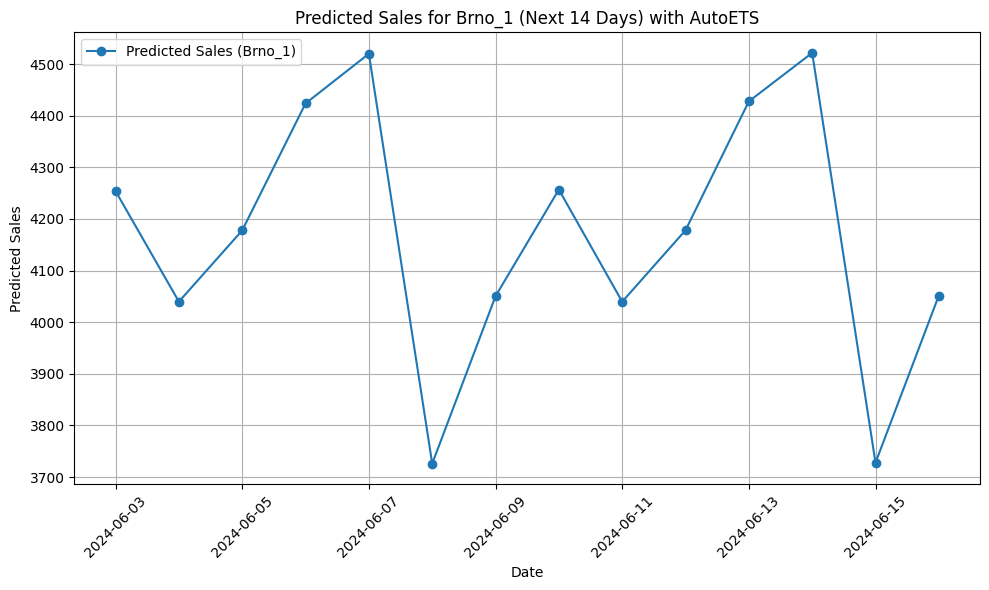

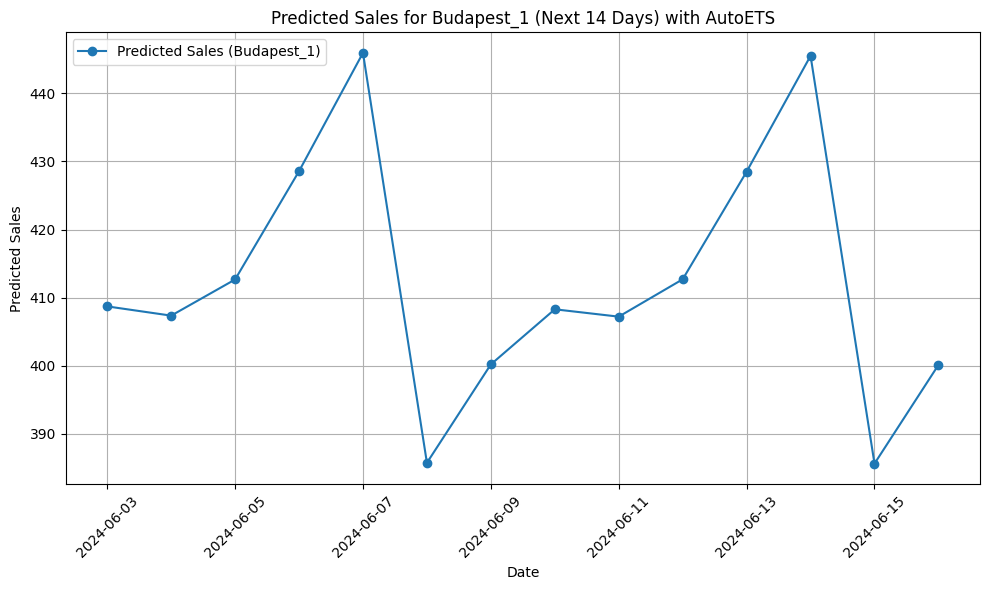

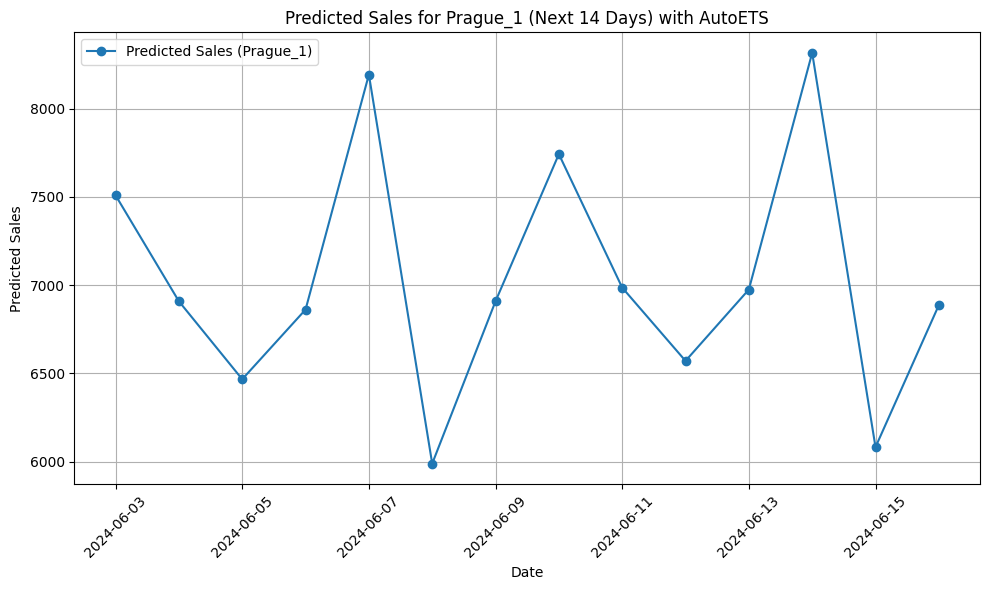

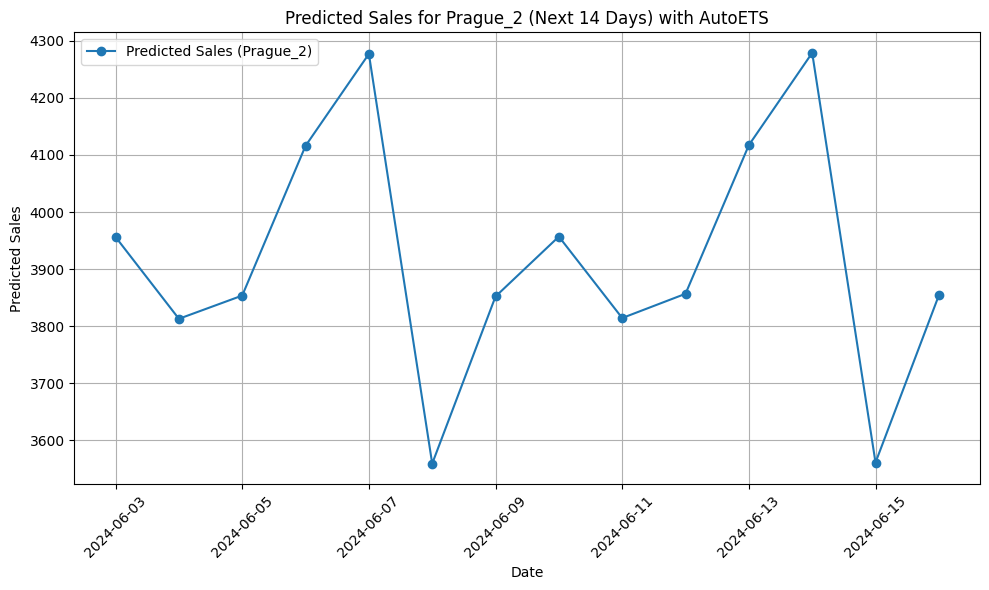

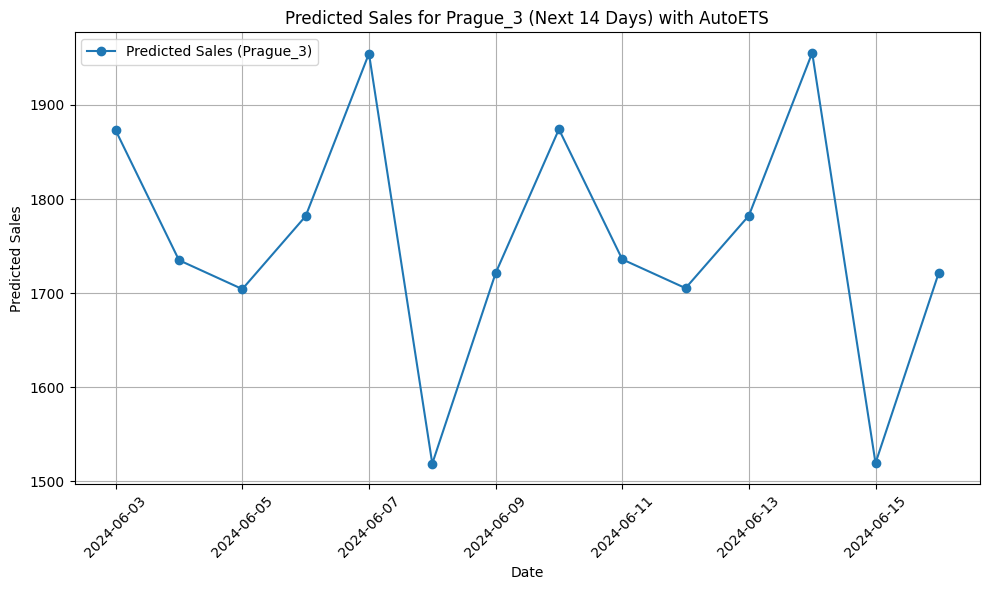

In [41]:
import matplotlib.pyplot as plt
warehouses = data_autoETS['warehouse'].unique()
for warehouse in warehouses:
    warehouse_data = daily_forecast_df[daily_forecast_df['warehouse'] == warehouse]
    
    # Plot the predicted sales for this warehouse
    plt.figure(figsize=(10, 6))
    plt.plot(warehouse_data['Date'], warehouse_data['Forecasted_Sales'], marker='o', label=f'Predicted Sales ({warehouse})')
    
    # Customize the plot
    plt.title(f'Predicted Sales for {warehouse} (Next 14 Days) with AutoETS')
    plt.xlabel('Date')
    plt.ylabel('Predicted Sales')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.savefig("AutoETS sales.png")
    plt.show()


In [42]:
#drawback of autoETS, very time-consuming

Neural Prophet

In [57]:
from neuralprophet import NeuralProphet
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import random

# Set random seed for reproducibility
seed = 42  # Any number you prefer
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

data = pd.read_csv('data_cleaned_50id.csv')
data.rename(columns={'sales': 'y', 'date': 'ds'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'], errors='coerce')
data.dropna(subset=['ds'], inplace=True)

# Rename columns for NeuralProphet
data.rename(columns={'sales': 'y'}, inplace=True)
# Rename the date column to 'ds' if necessary
data.rename(columns={'date': 'ds'}, inplace=True)  # Replace 'date' with the actual column name for dates

# Ensure 'ds' is a valid datetime column
data['ds'] = pd.to_datetime(data['ds'], errors='coerce')

# Drop rows with invalid dates if any
data.dropna(subset=['ds'], inplace=True)

# Proceed with the rest of the processing


# Ensure the necessary columns are present
assert 'ds' in data.columns, "Column 'ds' (dates) is missing."
assert 'y' in data.columns, "Column 'y' (sales) is missing."

# Define the MASE function
def calculate_mase(y_true, y_pred, y_train):
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    return mae_forecast / mae_naive

In [58]:
print(data.columns)

Index(['unique_id', 'ds', 'warehouse', 'y', 'sell_price_main', 'discount',
       'L1_category_name_en', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'category_Bakery',
       'category_Fruit and vegetable', 'category_Meat and fish',
       'warehouse_Brno_1', 'warehouse_Budapest_1', 'warehouse_Frankfurt_1',
       'warehouse_Munich_1', 'warehouse_Prague_1', 'warehouse_Prague_2',
       'warehouse_Prague_3', 'day_of_week', 'month'],
      dtype='object')


In [59]:
duplicates = data[data.duplicated(subset=['ds', 'warehouse'], keep=False)]
print(duplicates)


       unique_id         ds   warehouse       y  sell_price_main  discount  \
0           4540 2021-06-27  Budapest_1   60.61           316.11       0.0   
1           4540 2021-03-04  Budapest_1  100.09           316.11       0.0   
2           4540 2021-08-31  Budapest_1   38.74           316.11       0.0   
3           4540 2022-03-31  Budapest_1   51.09           358.41       0.0   
4           4540 2021-04-29  Budapest_1   63.21           316.11       0.0   
...          ...        ...         ...     ...              ...       ...   
70038       2602 2024-01-21  Budapest_1   13.16           568.34       0.0   
70039       2602 2022-05-13  Budapest_1   14.67           462.36       0.0   
70040       2602 2021-04-20  Budapest_1   25.37           356.39       0.0   
70041       2602 2023-06-10  Budapest_1   10.18           568.34       0.0   
70042       2602 2024-02-07  Budapest_1   16.15           568.34       0.0   

      L1_category_name_en  holiday  shops_closed  winter_school

In [60]:
data = data.groupby(['ds', 'warehouse'], as_index=False).agg({
    'y': 'sum',
    'holiday': 'first',
    'shops_closed': 'first',
    'winter_school_holidays': 'first'
})


In [61]:
assert not data.duplicated(subset=['ds', 'warehouse']).any(), "Duplicates still exist."


In [62]:
# Initialize results
mase_scores = []
store_results = {}

# Parameters
m = 70  # Number of observations to leave out for validation
h = 14   # Forecast horizon
n = m - h  # Number of rolling forecasts to generate

# Iterate over each unique store or warehouse in the data
for warehouse in tqdm(data['warehouse'].unique(), desc="Processing warehouses"):
    warehouse_data = data[data['warehouse'] == warehouse].copy()
    warehouse_data = warehouse_data.sort_values('ds').reset_index(drop=True)

    model = NeuralProphet(
        n_lags=7,
        n_forecasts=h,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        n_changepoints=10,
        changepoints_range=0.8
    )
    model.add_future_regressor('holiday')
    model.add_future_regressor('shops_closed')
    model.add_future_regressor('winter_school_holidays')
    # Split data into training and testing sets
    train_data = warehouse_data.iloc[:-m]
    
    # Train the model
    model.fit(train_data[['ds', 'y','holiday','shops_closed','winter_school_holidays']], freq="D", minimal=True, epochs=120)
    
    # Rolling forecast
    y_preds = []
    y_trues = []
    
    for i in range(n):
        forecast_data = warehouse_data.iloc[:-m + i + h].copy()

        # Make forecast
        forecast = model.predict(forecast_data[['ds', 'y','holiday','shops_closed','winter_school_holidays']])
        y_pred = forecast.iloc[-1][f"yhat{h}"]
        y_true = forecast.iloc[-1]['y']
        
        # Store true and predicted values
        y_preds.append(y_pred)
        y_trues.append(y_true)
    
    # Calculate MASE for the warehouse
    mase = calculate_mase(np.array(y_trues), np.array(y_preds), train_data['y'].values)
    store_results[warehouse] = mase
    mase_scores.append(mase)

# Calculate the average MASE across all warehouses
average_mase = np.mean(mase_scores)

# Create a DataFrame for the results
store_results_df = pd.DataFrame.from_dict(store_results, orient='index', columns=['MASE'])
store_results_df.loc['Average'] = average_mase

# Display the results
store_results_df


Processing warehouses:   0%|          | 0/5 [00:00<?, ?it/s]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.925% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (41) is too small than the required number                     for the learning rate finder (228). The results might not be optimal.


Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('reg_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\neuralprophet\data\split.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, 

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('reg_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\neuralprophet\data\split.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, 

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('reg_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\neuralprophet\data\split.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, 

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('reg_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\neuralprophet\data\split.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, 

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\core\module.py:516: You called `self.log('reg_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\neuralprophet\data\split.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, 

,MASE
Brno_1,0.864135
Budapest_1,0.753078
Prague_1,1.202864
Prague_2,0.798415
Prague_3,0.935455
Average,0.910789


In [17]:
data = pd.read_csv('data_cleaned_50id.csv')
data.rename(columns={'sales': 'y', 'date': 'ds'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'], errors='coerce')
data.dropna(subset=['ds'], inplace=True)


In [18]:
# Filter the data for Prague_1 and Prague_2
prague_data = data[data['warehouse'].isin(['Prague_1'])]

# Check for missing values
missing_values = prague_data.isnull().sum()

# Check basic statistics for these warehouses
prague_stats = prague_data.groupby('warehouse')['y'].describe()

# Display results
print(missing_values)
print(prague_stats)


unique_id                       0
ds                              0
warehouse                       0
y                               0
sell_price_main                 0
discount                        0
L1_category_name_en             0
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
category_Bakery                 0
category_Fruit and vegetable    0
category_Meat and fish          0
warehouse_Brno_1                0
warehouse_Budapest_1            0
warehouse_Frankfurt_1           0
warehouse_Munich_1              0
warehouse_Prague_1              0
warehouse_Prague_2              0
warehouse_Prague_3              0
day_of_week                     0
month                           0
dtype: int64
             count        mean       std  min    25%     50%       75%  \
warehouse                                                                
Prague_1   16812.0  255.746376  490.5613  0.0  19.85  35.

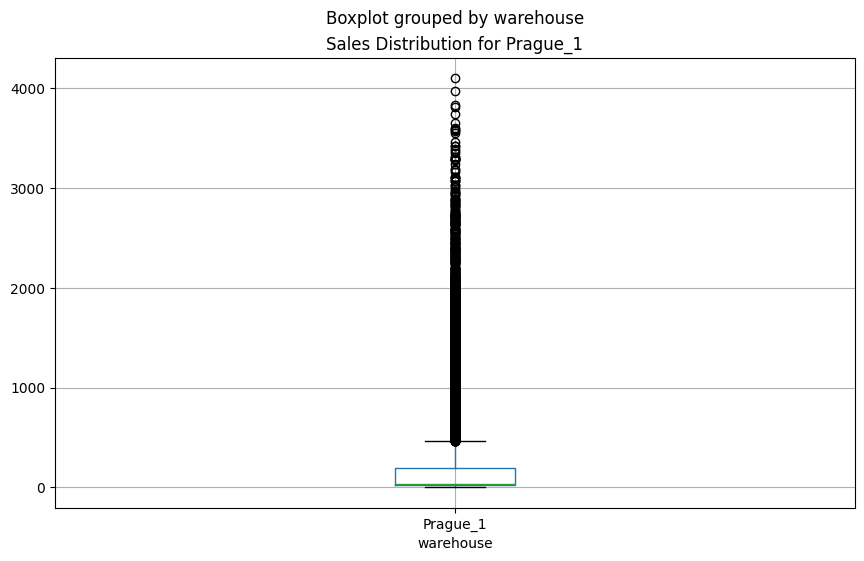

In [19]:
import matplotlib.pyplot as plt

prague_data.boxplot(column='y', by='warehouse', figsize=(10, 6))
plt.title('Sales Distribution for Prague_1')
plt.show()


In [44]:
# Step 1: Apply the 5% cap to Prague_1 warehouse only
cap_value_prague_1 = prague_data['y'].quantile(0.95)  # 95th percentile for Prague_1
data_capped = data.copy()

# Apply the cap only to Prague_1 warehouse
data_capped['y'] = np.where(
    (data_capped['warehouse'] == 'Prague_1') & (data_capped['y'] > cap_value_prague_1),
    cap_value_prague_1,
    data_capped['y']
)

# Check the capped data
print(f"Original max sales (Prague_1): {prague_data['y'].max()}")
print(f"Capped max sales (Prague_1): {cap_value_prague_1}")
print(f"Number of capped values (Prague_1): {sum((prague_data['y'] > cap_value_prague_1))}")


Original max sales (Prague_1): 4102.56
Capped max sales (Prague_1): 1402.2079999999994
Number of capped values (Prague_1): 841


In [48]:
from neuralprophet import NeuralProphet
from tqdm import tqdm
import numpy as np

# Define the calculate_mase function
def calculate_mase(y_true, y_pred, train_series, seasonality=1):
    """
    Calculate the Mean Absolute Scaled Error (MASE).
    
    Args:
        y_true (np.ndarray): Array of true values.
        y_pred (np.ndarray): Array of predicted values.
        train_series (np.ndarray): Training data series to calculate naive forecast errors.
        seasonality (int): The seasonality (e.g., 1 for daily data, 7 for weekly seasonality).

    Returns:
        float: The MASE value.
    """
    # Mean Absolute Error (MAE) of the predictions
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Naive forecast errors based on the training series
    naive_forecast = train_series[:-seasonality]
    naive_errors = np.abs(train_series[seasonality:] - naive_forecast)
    
    # Mean Absolute Error (MAE) of the naive forecast
    scaling_factor = np.mean(naive_errors)
    
    # Return MASE
    if scaling_factor == 0:
        return np.nan  # Avoid division by zero
    return mae / scaling_factor


# NeuralProphet Model Training with MASE Calculation
# Initialize results
mase_scores = []
store_results = {}

# Parameters
m = 70  # Number of observations to leave out for validation
h = 14   # Forecast horizon
n = m - h  # Number of rolling forecasts to generate

# Remove duplicates explicitly (to avoid errors)
data_capped = data_capped.drop_duplicates(subset=['ds', 'warehouse'])

# Iterate over each unique warehouse in the data
for warehouse in tqdm(data_capped['warehouse'].unique(), desc="Processing warehouses"):
    warehouse_data = data_capped[data_capped['warehouse'] == warehouse].copy()
    warehouse_data = warehouse_data.sort_values('ds').reset_index(drop=True)
    
    # Final duplicate check for this warehouse
    assert not warehouse_data.duplicated(subset='ds').any(), f"Duplicates still exist in {warehouse}!"

    model = NeuralProphet(
        n_lags=7,
        n_forecasts=h,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        n_changepoints=10,
        changepoints_range=0.8
    )
    model.add_future_regressor('holiday')
    model.add_future_regressor('shops_closed')
    model.add_future_regressor('winter_school_holidays')
    
    # Split data into training and testing sets
    train_data = warehouse_data.iloc[:-m]
    
    # Final duplicate check for train_data
    assert not train_data.duplicated(subset='ds').any(), f"Duplicates exist in train_data for {warehouse}!"
    
    # Train the model
    model.fit(train_data[['ds', 'y', 'holiday', 'shops_closed', 'winter_school_holidays']], freq="D", minimal=True, epochs=120)
    
    # Rolling forecast
    y_preds = []
    y_trues = []
    
    for i in range(n):
        forecast_data = warehouse_data.iloc[:-m + i + h].copy()

        # Make forecast
        forecast = model.predict(forecast_data[['ds', 'y', 'holiday', 'shops_closed', 'winter_school_holidays']])
        y_pred = forecast.iloc[-1][f"yhat{h}"]
        y_true = forecast.iloc[-1]['y']
        
        # Store true and predicted values
        y_preds.append(y_pred)
        y_trues.append(y_true)
    
    # Calculate MASE for the warehouse
    mase = calculate_mase(
        y_true=np.array(y_trues),
        y_pred=np.array(y_preds),
        train_series=train_data['y'].values,
        seasonality=7  # Weekly seasonality
    )
    store_results[warehouse] = mase
    mase_scores.append(mase)

# Calculate the average MASE across all warehouses
average_mase = np.mean(mase_scores)

# Create a DataFrame for the results
store_results_df = pd.DataFrame.from_dict(store_results, orient='index', columns=['MASE'])
store_results_df.loc['Average'] = average_mase

# Display the results
print(store_results_df)


Processing warehouses:   0%|                              | 0/5 [00:00<?, ?it/s]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.925% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (41) is too small than the required number                     for the learning rate finder (228). The results might not be optimal.


Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at the end with NaNs in future regressors.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.927% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at t

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at the end with NaNs in future regressors.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.927% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at t

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at the end with NaNs in future regressors.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.927% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at t

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at the end with NaNs in future regressors.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.927% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at t

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at the end with NaNs in future regressors.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.927% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows at t

                MASE
Budapest_1  0.514298
Prague_2    1.060759
Prague_3    0.939768
Brno_1      0.492647
Prague_1    0.552161
Average     0.711927


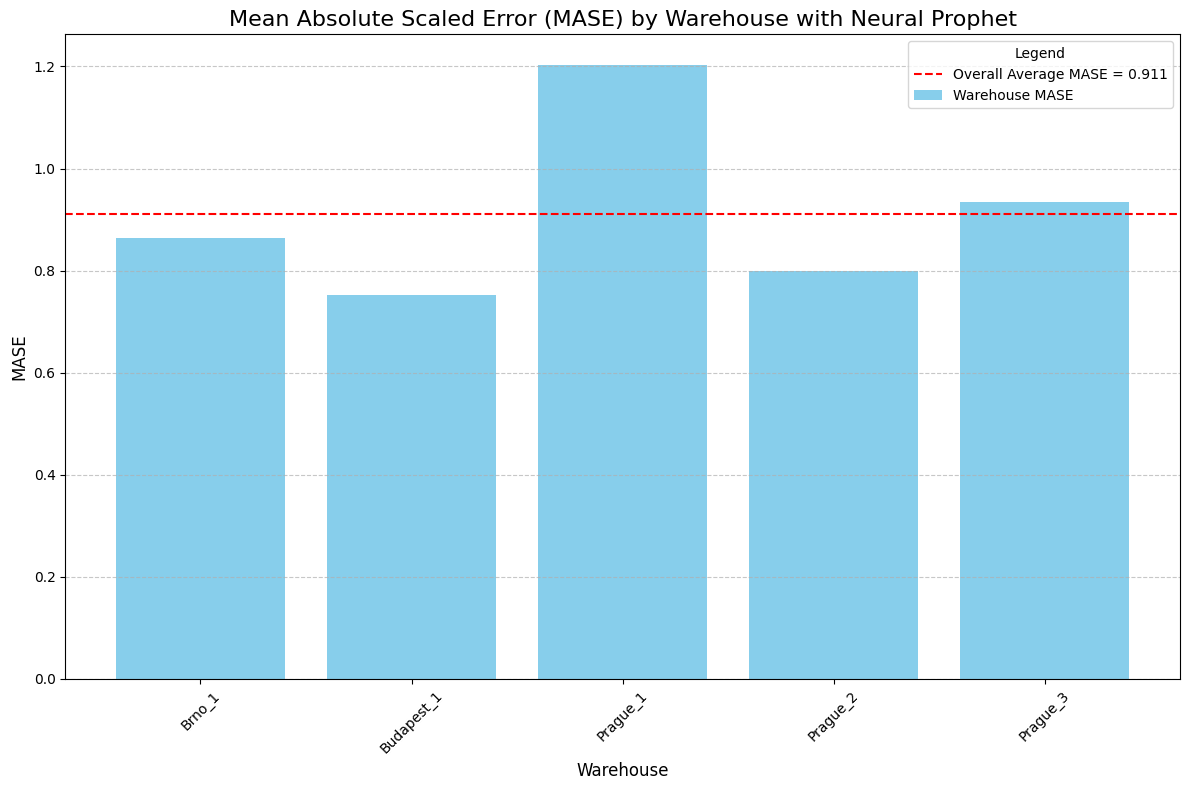

In [63]:
import matplotlib.pyplot as plt

# Extract warehouse names and MASE values, excluding the "Average" row
warehouse_names = store_results_df.index[:-1]  # All except the last row ("Average")
mase_values = store_results_df['MASE'][:-1]   # MASE values for warehouses

# Extract the Average MASE for the horizontal line
average_mase = store_results_df.loc['Average', 'MASE']

# Plot the MASE for each warehouse
plt.figure(figsize=(12, 8))
plt.bar(warehouse_names, mase_values, color='skyblue', label='Warehouse MASE')

# Add a horizontal line for the overall average MASE
plt.axhline(y=average_mase, color='red', linestyle='--', label=f'Overall Average MASE = {average_mase:.3f}')

# Customize the plot
plt.title('Mean Absolute Scaled Error (MASE) by Warehouse with Neural Prophet', fontsize=16)
plt.xlabel('Warehouse', fontsize=12)
plt.ylabel('MASE', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Legend', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show and save the plot
plt.tight_layout()
plt.savefig("Neural_Prophet_MASE.png")
plt.show()


lightgbm

In [50]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm

# Step 1: Preprocessing
data = pd.read_csv('data_cleaned_50id.csv')

# Rename columns for consistency
data.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'], errors='coerce')
data.dropna(subset=['ds'], inplace=True)

data = data.groupby(['ds', 'warehouse'], as_index=False).agg({
    'y': 'sum',
    'holiday': 'first',
    'shops_closed': 'first',
    'winter_school_holidays': 'first'
})

categorical_columns = ['warehouse']
for col in categorical_columns:
    if col in data.columns:
        data[col] = data[col].astype('category')

# Feature engineering
def create_features(df):
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['month'] = df['ds'].dt.month
    df['lag_1'] = df['y'].shift(1)
    df['lag_7'] = df['y'].shift(7)
    df['rolling_mean_7'] = df['y'].shift(1).rolling(window=7).mean()
    df['rolling_std_7'] = df['y'].shift(1).rolling(window=7).std()
    df.dropna(inplace=True)
    return df

data = create_features(data)


# Step 2: Leave-One-Out Cross-Validation Function
def loocv_lgb_by_warehouse_with_mase(data, target_col, features, seasonality=7, h=14, m=28):
    warehouse_performance = []
    
    warehouse_iterator = tqdm(data['warehouse'].unique(), desc="Processing Warehouses", unit="warehouse")
    
    # Iterate over each warehousefor warehouse_id in warehouse_iterator:
    for warehouse_id in warehouse_iterator:    
        mase_scores = []
        
        # Filter and sort data for the current warehouseKK
        warehouse_data = data[data['warehouse'] == warehouse_id].sort_values('ds').reset_index(drop=True)
        
        # Perform leave-one-out cross-validation for the last m periods
        for i in range(len(warehouse_data) - m, len(warehouse_data)):
            train_data = warehouse_data.iloc[:i]  # Train up to point i
            val_data = warehouse_data.iloc[i:i + h]  # Predict h steps ahead
            
            # Ensure validation data exists
            if len(val_data) < h:
                continue
            
            train_x = train_data[features]
            train_y = train_data[target_col]
            val_x = val_data[features]
            val_y = val_data[target_col]
            
            # LightGBM model
            train_dataset = lgb.Dataset(
                train_x,
                label=train_y,
                categorical_feature=[col for col in categorical_columns if col in features]
            )
            
            # Define LightGBM parameters
            params = {
                "objective": "regression",
                "metric": "mae",
                "learning_rate": 0.1,
                "max_depth": 6,
                "num_leaves": 31,
                "verbosity": -1
            }
            
            # Train the model
            model = lgb.train(
                params,
                train_dataset,
                num_boost_round=1000
            )
            # Validation predictions
            val_preds = model.predict(val_x)
            
            # Calculate MASE
            mae = np.mean(np.abs(val_y - val_preds))
            naive_forecast = train_y.shift(seasonality).iloc[seasonality:]
            naive_errors = np.abs(train_y[seasonality:] - naive_forecast)
            scaling_factor = naive_errors.mean()
            mase = mae / scaling_factor if scaling_factor > 0 else np.nan
            mase_scores.append(mase)
        
        # Store average MASE for the warehouse
        warehouse_performance.append({
            "Warehouse": warehouse_id,
            "Average MASE": np.nanmean(mase_scores)  # Handle NaN values if no valid MASE
        })
    
    # Convert results to a DataFrame
    performance_df = pd.DataFrame(warehouse_performance)
    
    # Calculate overall average MASE
    overall_mase = performance_df['Average MASE'].mean()
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame([{"Warehouse": "Overall Average", "Average MASE": overall_mase}])
    ], ignore_index=True)
    
    return performance_df

# Step 3: Run Cross-Validation and Evaluate
target = 'y'
features = [col for col in data.columns if col not in ['ds', 'y', 'warehouse']]

# Run leave-one-out cross-validation and get MASE performance per warehouse
performance_df = loocv_lgb_by_warehouse_with_mase(data, target, features, seasonality=7, h=14, m=70)

# Display the performance table
print(performance_df)


Processing Warehouses: 100%|██████████| 5/5 [02:18<00:00, 27.80s/warehouse]

         Warehouse  Average MASE
0         Prague_1      0.754847
1         Prague_2      1.749100
2         Prague_3      0.551682
3           Brno_1      0.727145
4       Budapest_1      1.609829
5  Overall Average      1.078521


In [51]:

def predict_future_sales_14_days(data, target_col, features):
    predictions = []
    h = 14  # Fixed to predict the next 14 days
    
    # Initialize progress bar for warehouses
    warehouse_iterator = tqdm(data['warehouse'].unique(), desc="Predicting Warehouses", unit="warehouse")
    
    for warehouse_id in warehouse_iterator:
        warehouse_data = data[data['warehouse'] == warehouse_id].sort_values('ds').reset_index(drop=True)
        
        train_x = warehouse_data[features]
        train_y = warehouse_data[target_col]

        train_dataset = lgb.Dataset(
            train_x,
            label=train_y,
             categorical_feature=[col for col in categorical_columns if col in features]
            
        )
        
    
        
        params = {
            "objective": "regression",
            "metric": "mae",
            "learning_rate": 0.1,
            "max_depth": 6,
            "num_leaves": 31,
            "verbosity": -1
        }
        
        model = lgb.train(
            params,
            train_dataset,
            num_boost_round=1000
        )
        
        # Generate future dates for the next 14 days
        future_dates = pd.date_range(
            start=warehouse_data['ds'].max() + pd.Timedelta(days=1),
            periods=h,
            freq='D'
        )
        future_df = pd.DataFrame({'ds': future_dates})
        future_df['day_of_week'] = future_df['ds'].dt.dayofweek
        future_df['month'] = future_df['ds'].dt.month
        future_df['lag_1'] = warehouse_data['y'].iloc[-1]
        future_df['lag_7'] = warehouse_data['y'].iloc[-7:].mean()
        future_df['rolling_mean_7'] = warehouse_data['y'].rolling(window=7).mean().iloc[-1]
        future_df['rolling_std_7'] = warehouse_data['y'].rolling(window=7).std().iloc[-1]
        future_df['holiday']=warehouse_data['holiday']
        future_df['shops_closed']=warehouse_data['shops_closed']
        future_df['winter_school_holidays']=warehouse_data['winter_school_holidays']


        for col in categorical_columns:
            if col in warehouse_data.columns:
                future_df[col] = warehouse_data[col].iloc[-1]

    
        
        future_x = future_df[features]
        future_preds = model.predict(future_x)
        future_df['predicted_sales'] = future_preds
        future_df['warehouse'] = warehouse_id
        
        predictions.append(future_df[['ds', 'warehouse', 'predicted_sales']])
    
    predictions_df = pd.concat(predictions, ignore_index=True)
    return predictions_df

# Predict future sales for the next 14 days
future_sales = predict_future_sales_14_days(data, target, features)

# Display predictions
print(future_sales)

Predicting Warehouses: 100%|██████████| 5/5 [00:03<00:00,  1.43warehouse/s]

           ds   warehouse  predicted_sales
0  2024-06-03    Prague_1      3305.907138
1  2024-06-04    Prague_1      3153.155975
2  2024-06-05    Prague_1      3135.153596
3  2024-06-06    Prague_1      3175.244135
4  2024-06-07    Prague_1      3133.279134
..        ...         ...              ...
65 2024-06-12  Budapest_1       878.514663
66 2024-06-13  Budapest_1       841.263086
67 2024-06-14  Budapest_1       784.994324
68 2024-06-15  Budapest_1       736.631035
69 2024-06-16  Budapest_1       789.479964

[70 rows x 3 columns]


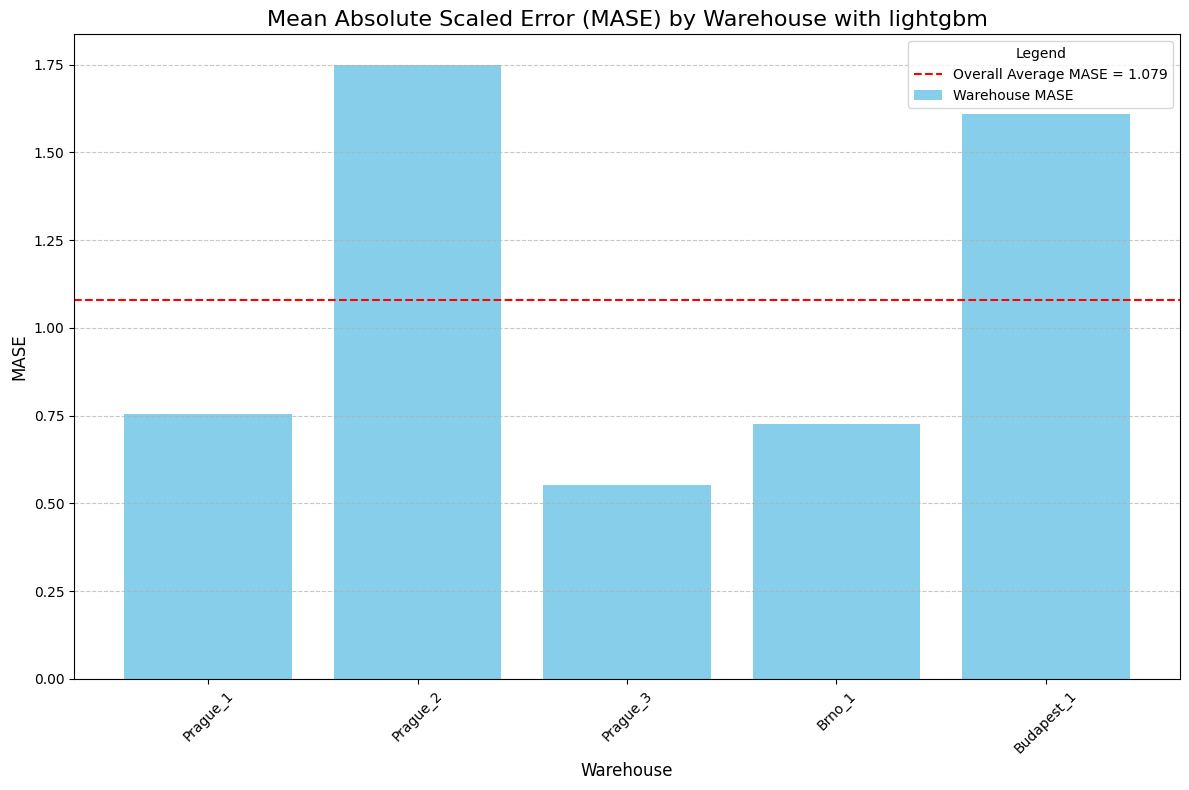

In [52]:
import matplotlib.pyplot as plt

# Assuming `performance_df` is already computed from loocv_lgb_by_warehouse_with_mase
# It contains "Warehouse" and "Average MASE" columns

# Exclude the overall average from the bar chart
warehouse_mase = performance_df[performance_df['Warehouse'] != 'Overall Average']

# Extract the overall average MASE for comparison
overall_mase = performance_df[performance_df['Warehouse'] == 'Overall Average']['Average MASE'].values[0]

# Plot the MASE for each warehouse
plt.figure(figsize=(12, 8))
plt.bar(warehouse_mase['Warehouse'], warehouse_mase['Average MASE'], color='skyblue', label='Warehouse MASE')

# Add a horizontal line for the overall average MASE
plt.axhline(y=overall_mase, color='red', linestyle='--', label=f'Overall Average MASE = {overall_mase:.3f}')

# Customize the plot
plt.title('Mean Absolute Scaled Error (MASE) by Warehouse with lightgbm', fontsize=16)
plt.xlabel('Warehouse', fontsize=12)
plt.ylabel('MASE', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Legend', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("lightgbm MASE.png")
plt.show()

Predicting Warehouses: 100%|██████████| 5/5 [00:03<00:00,  1.35warehouse/s]


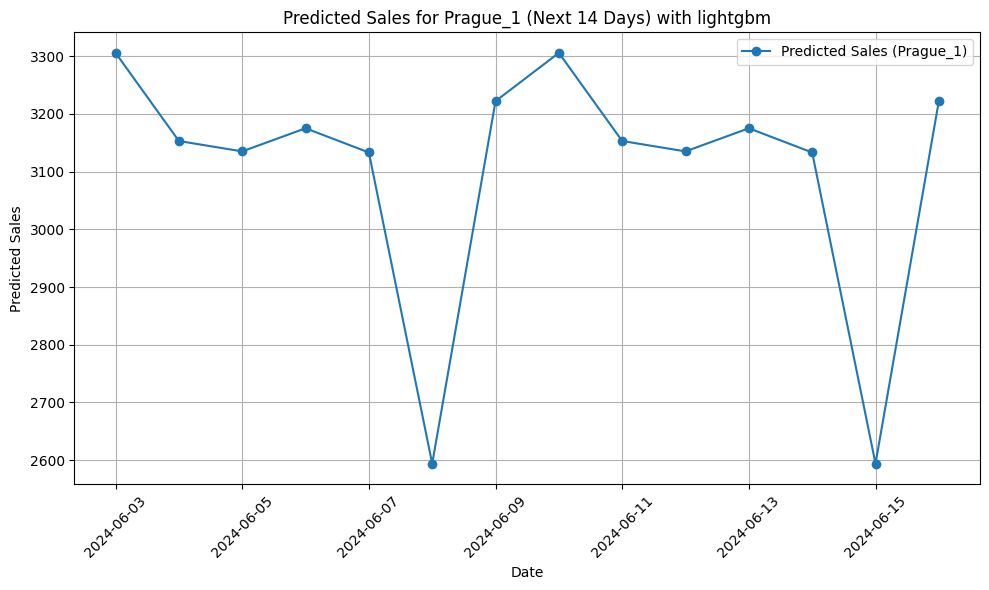

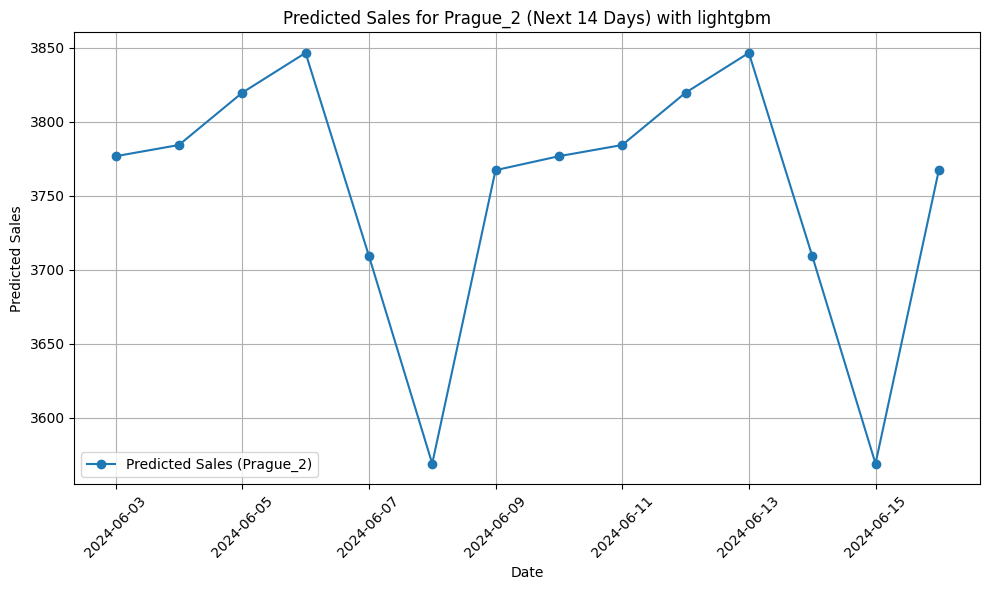

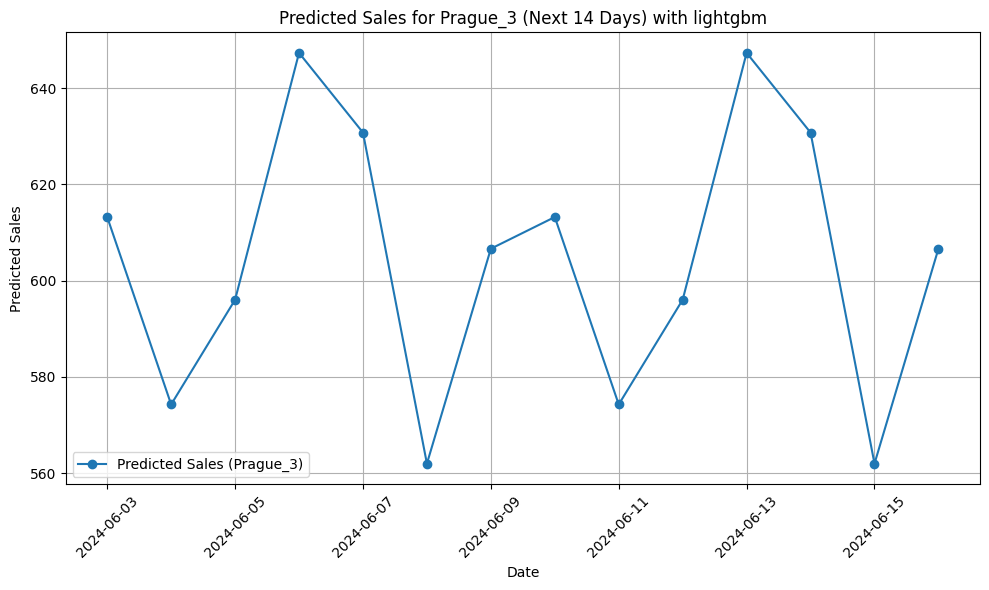

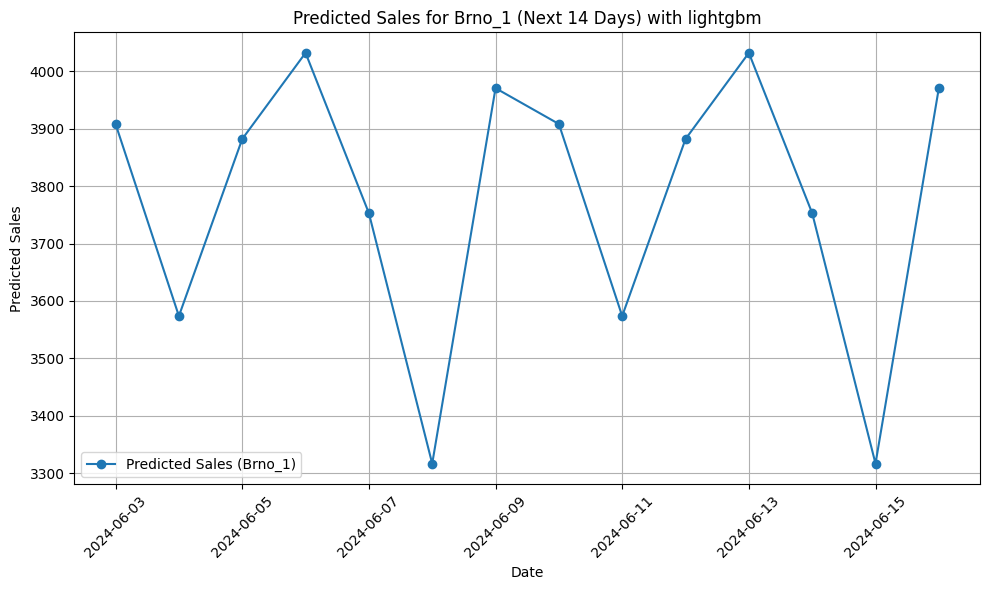

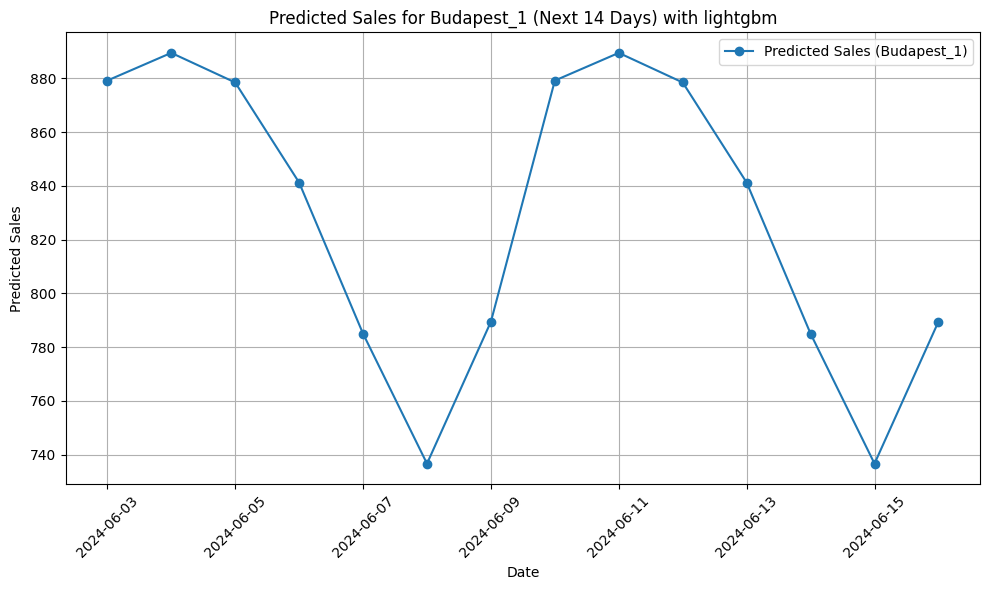

In [53]:
import matplotlib.pyplot as plt

# Step 1: Predict Future Sales for the Next 14 Days
future_sales = predict_future_sales_14_days(data, target, features)

# Step 2: Plot the predictions for each warehouse
warehouses = future_sales['warehouse'].unique()

# Create a plot for each warehouse
for warehouse in warehouses:
    warehouse_data = future_sales[future_sales['warehouse'] == warehouse]
    
    # Plot the predicted sales for this warehouse
    plt.figure(figsize=(10, 6))
    plt.plot(warehouse_data['ds'], warehouse_data['predicted_sales'], marker='o', label=f'Predicted Sales ({warehouse})')
    
    # Customize the plot
    plt.title(f'Predicted Sales for {warehouse} (Next 14 Days) with lightgbm')
    plt.xlabel('Date')
    plt.ylabel('Predicted Sales')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.savefig("Lightgbm Profit MASE.png")
    plt.show()
